In [26]:
import collections
import pickle
import os

from headers.training import *
from headers.models import *
from headers.A2C_agent import *
from headers.helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data and agents

In [27]:

# # Load all_* dictionaries
# with open('agent1_data/all_dicts.pkl', 'rb') as f:
#     all_critic_losses, all_actor_losses, all_episode_rewards, \
#         all_evaluation_reward_means, all_evaluation_reward_stds, all_evaluation_value_trajectories = pickle.load(f)

# # Load agent1 dictionary
# with open('agent1_data/agent1.pkl', 'rb') as f:
#     agent1 = pickle.load(f)

# 3.4 Agent 3: n-step returns


In [28]:
# hyperparameters
stochastic_rewards = False
k=1
n=6
total_steps_budget = 500000
device = "cpu"
seeds = [1, 101, 1101]

agent, \
all_critic_losses, all_actor_losses, all_episode_rewards, \
all_evaluation_reward_means, all_evaluation_reward_stds, all_evaluation_value_trajectories \
= training_loop(seeds, total_steps_budget, k, n, stochastic_rewards, device)

-------- Episode 100 ended with reward 52.0 for model 0 --------
Actor loss: -2.1759, Critic loss: 63.8187
Total steps taken during training: 2475
-------- Episode 200 ended with reward 26.0 for model 0 --------
Actor loss: -3.6341, Critic loss: 141.5590
Total steps taken during training: 5027
-------- Episode 300 ended with reward 13.0 for model 0 --------
Actor loss: -17.5628, Critic loss: 438.4264
Total steps taken during training: 7680
-------- Episode 400 ended with reward 68.0 for model 0 --------
Actor loss: -1.4574, Critic loss: 4.0316
Total steps taken during training: 10409
-------- Episode 500 ended with reward 33.0 for model 0 --------
Actor loss: -1.2967, Critic loss: 51.8182
Total steps taken during training: 13293
-------- Episode 600 ended with reward 69.0 for model 0 --------
Actor loss: -1.0155, Critic loss: 14.4412
Total steps taken during training: 17033
---- Proceeding to evaluate model 0 ... ----
Mean reward: 62.70, Std reward: 7.44, total steps: 20000
----     Ev

### training logging info

- losses and rewards are every 1k step
- evaluation rewards and value_trajectories are every 20k steps

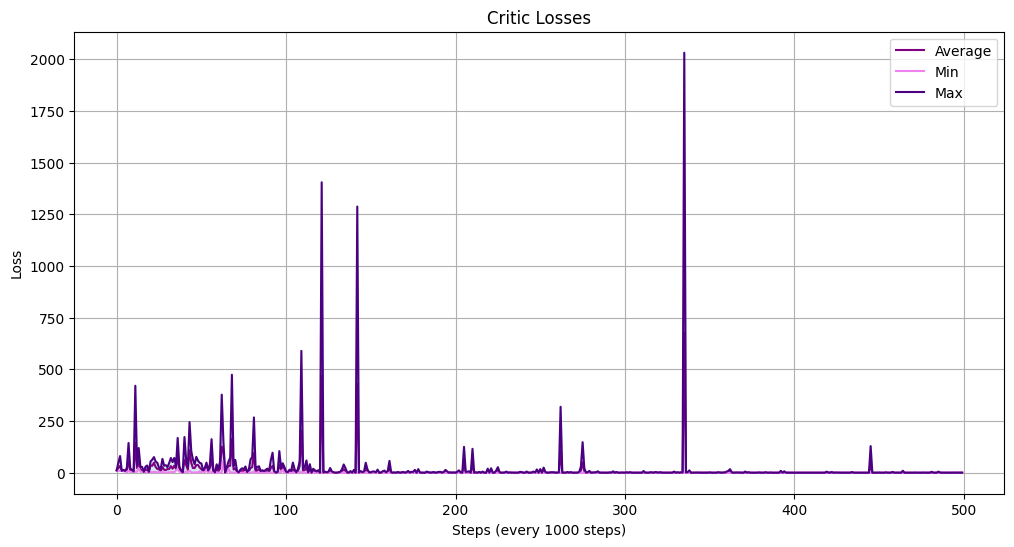

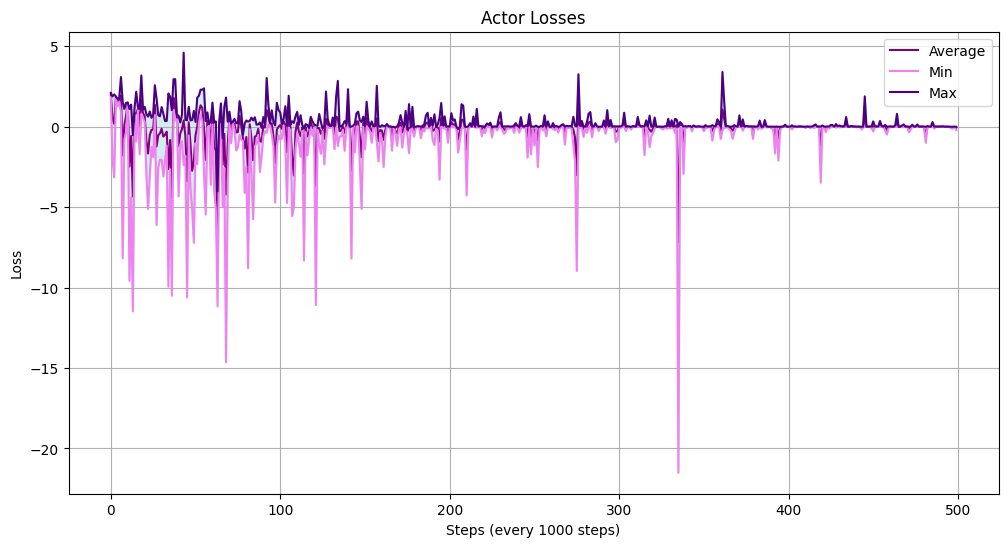

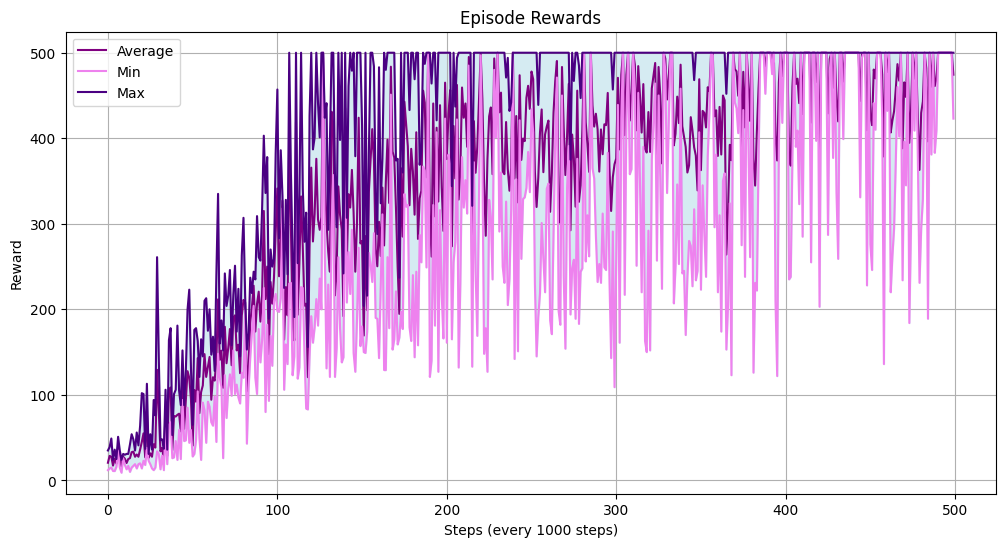

In [37]:
# Get stats 
min_critic_losses, max_critic_losses, avg_critic_losses = get_stats(all_critic_losses)
min_actor_losses, max_actor_losses, avg_actor_losses = get_stats(all_actor_losses)
min_episode_rewards, max_episode_rewards, avg_episode_rewards = get_stats(all_episode_rewards)

save_plots = True
folder_name = 'agent3'

# Plot stats 
plot_stats(save_plots, folder_name, min_critic_losses, max_critic_losses, avg_critic_losses, title='Critic Losses', ylabel='Loss', xlabel='Steps (every 1000 steps)')
plot_stats(save_plots, folder_name, min_actor_losses, max_actor_losses, avg_actor_losses, title='Actor Losses', ylabel='Loss', xlabel='Steps (every 1000 steps)')
plot_stats(save_plots, folder_name, min_episode_rewards, max_episode_rewards, avg_episode_rewards, title='Episode Rewards', ylabel='Reward', xlabel='Steps (every 1000 steps)')

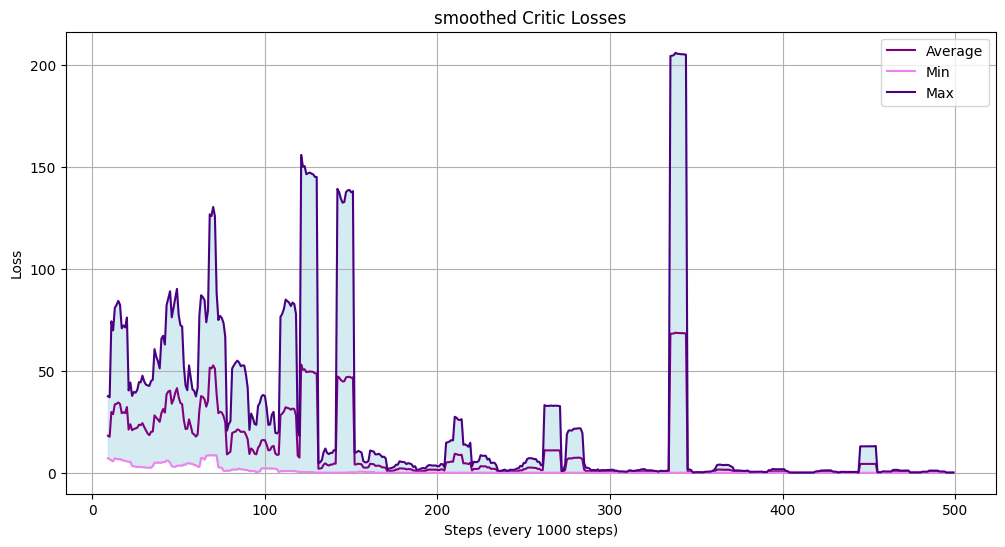

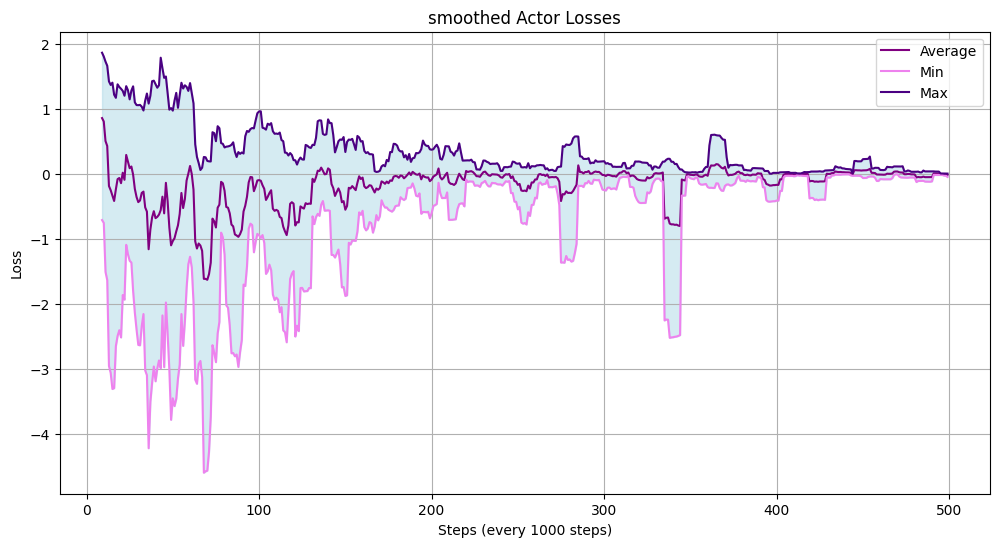

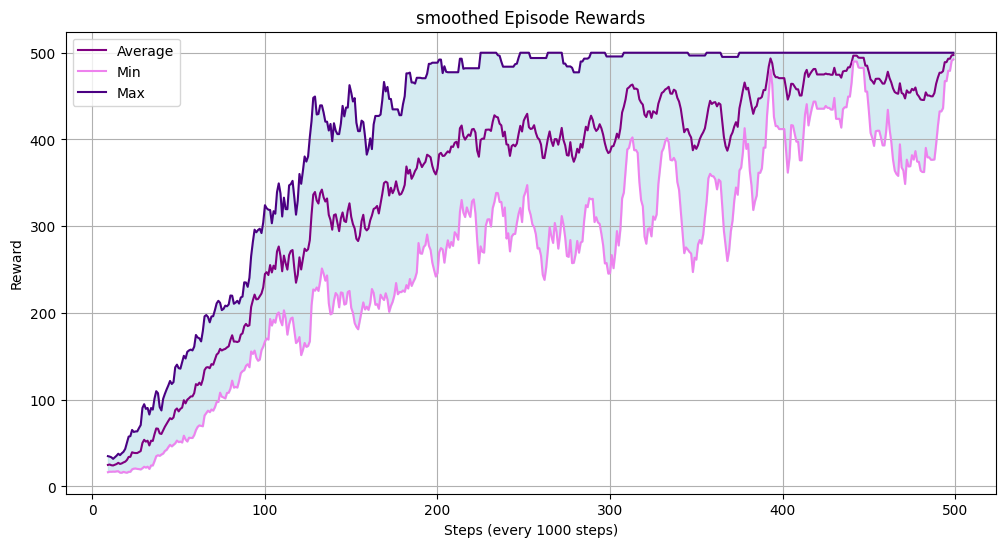

In [38]:
# Plot smoothed stats 
window_size = 10

plot_smoothed_stats(save_plots, folder_name, min_critic_losses, max_critic_losses, avg_critic_losses, window_size, title='smoothed Critic Losses', ylabel='Loss', xlabel='Steps (every 1000 steps)')
plot_smoothed_stats(save_plots, folder_name, min_actor_losses, max_actor_losses, avg_actor_losses, window_size, title='smoothed Actor Losses', ylabel='Loss', xlabel='Steps (every 1000 steps)')
plot_smoothed_stats(save_plots, folder_name, min_episode_rewards, max_episode_rewards, avg_episode_rewards, window_size, title='smoothed Episode Rewards', ylabel='Reward', xlabel='Steps (every 1000 steps)')

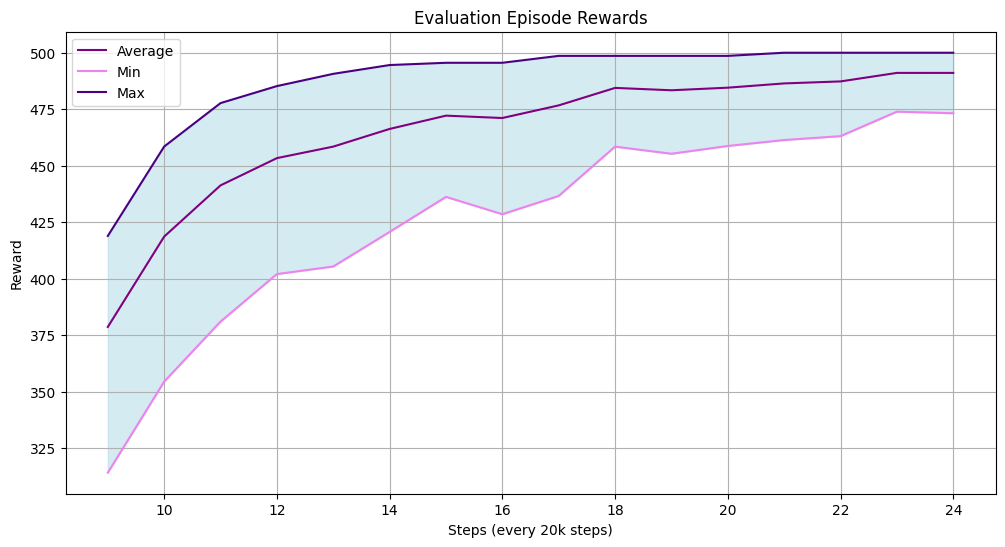

In [39]:
# Get stats for evaluation rewards
min_eval_rew, max_eval_rew, avg_eval_rew = get_stats(all_evaluation_reward_means)

# Plot stats
plot_smoothed_stats(save_plots, folder_name, min_eval_rew, max_eval_rew, avg_eval_rew, window_size, title='Evaluation Episode Rewards',ylabel='Reward',xlabel='Steps (every 20k steps)')

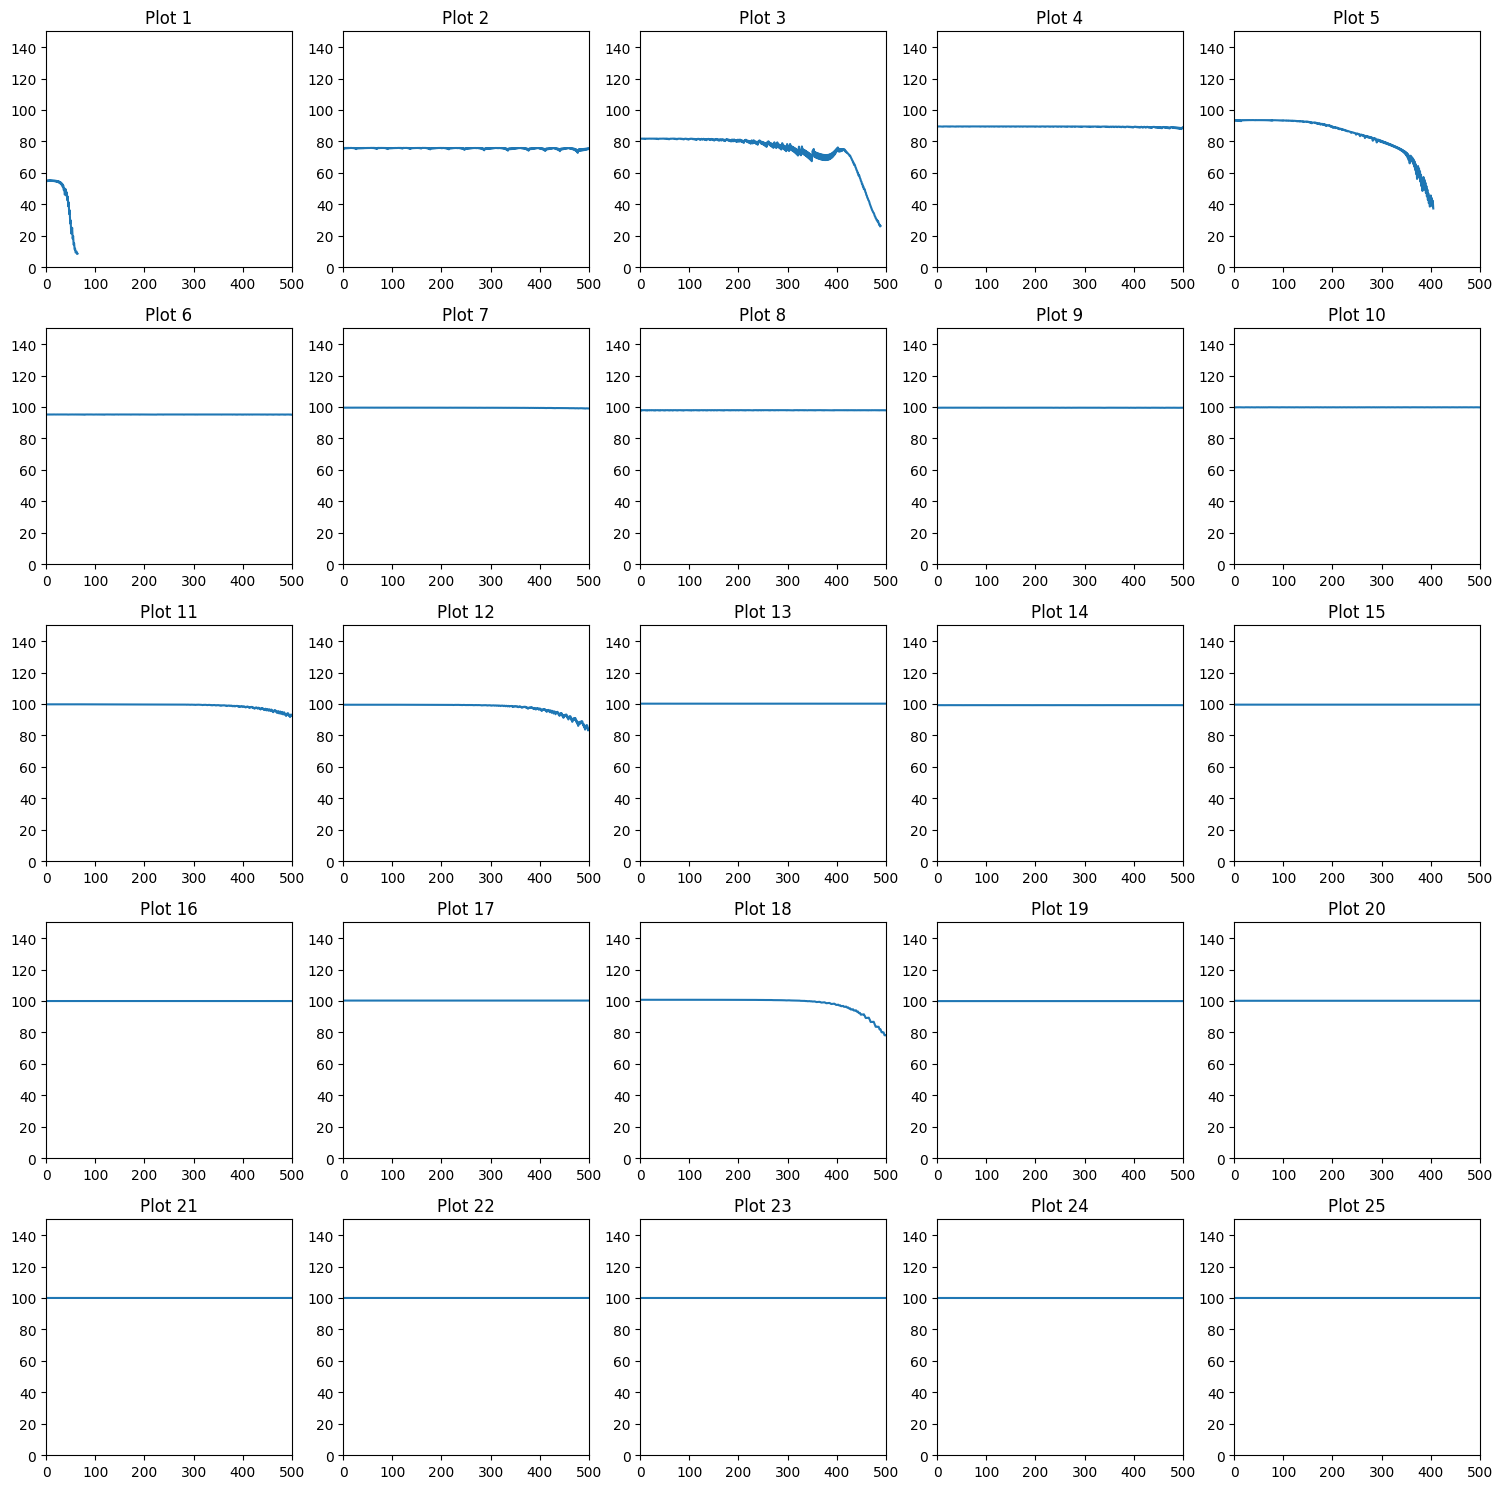

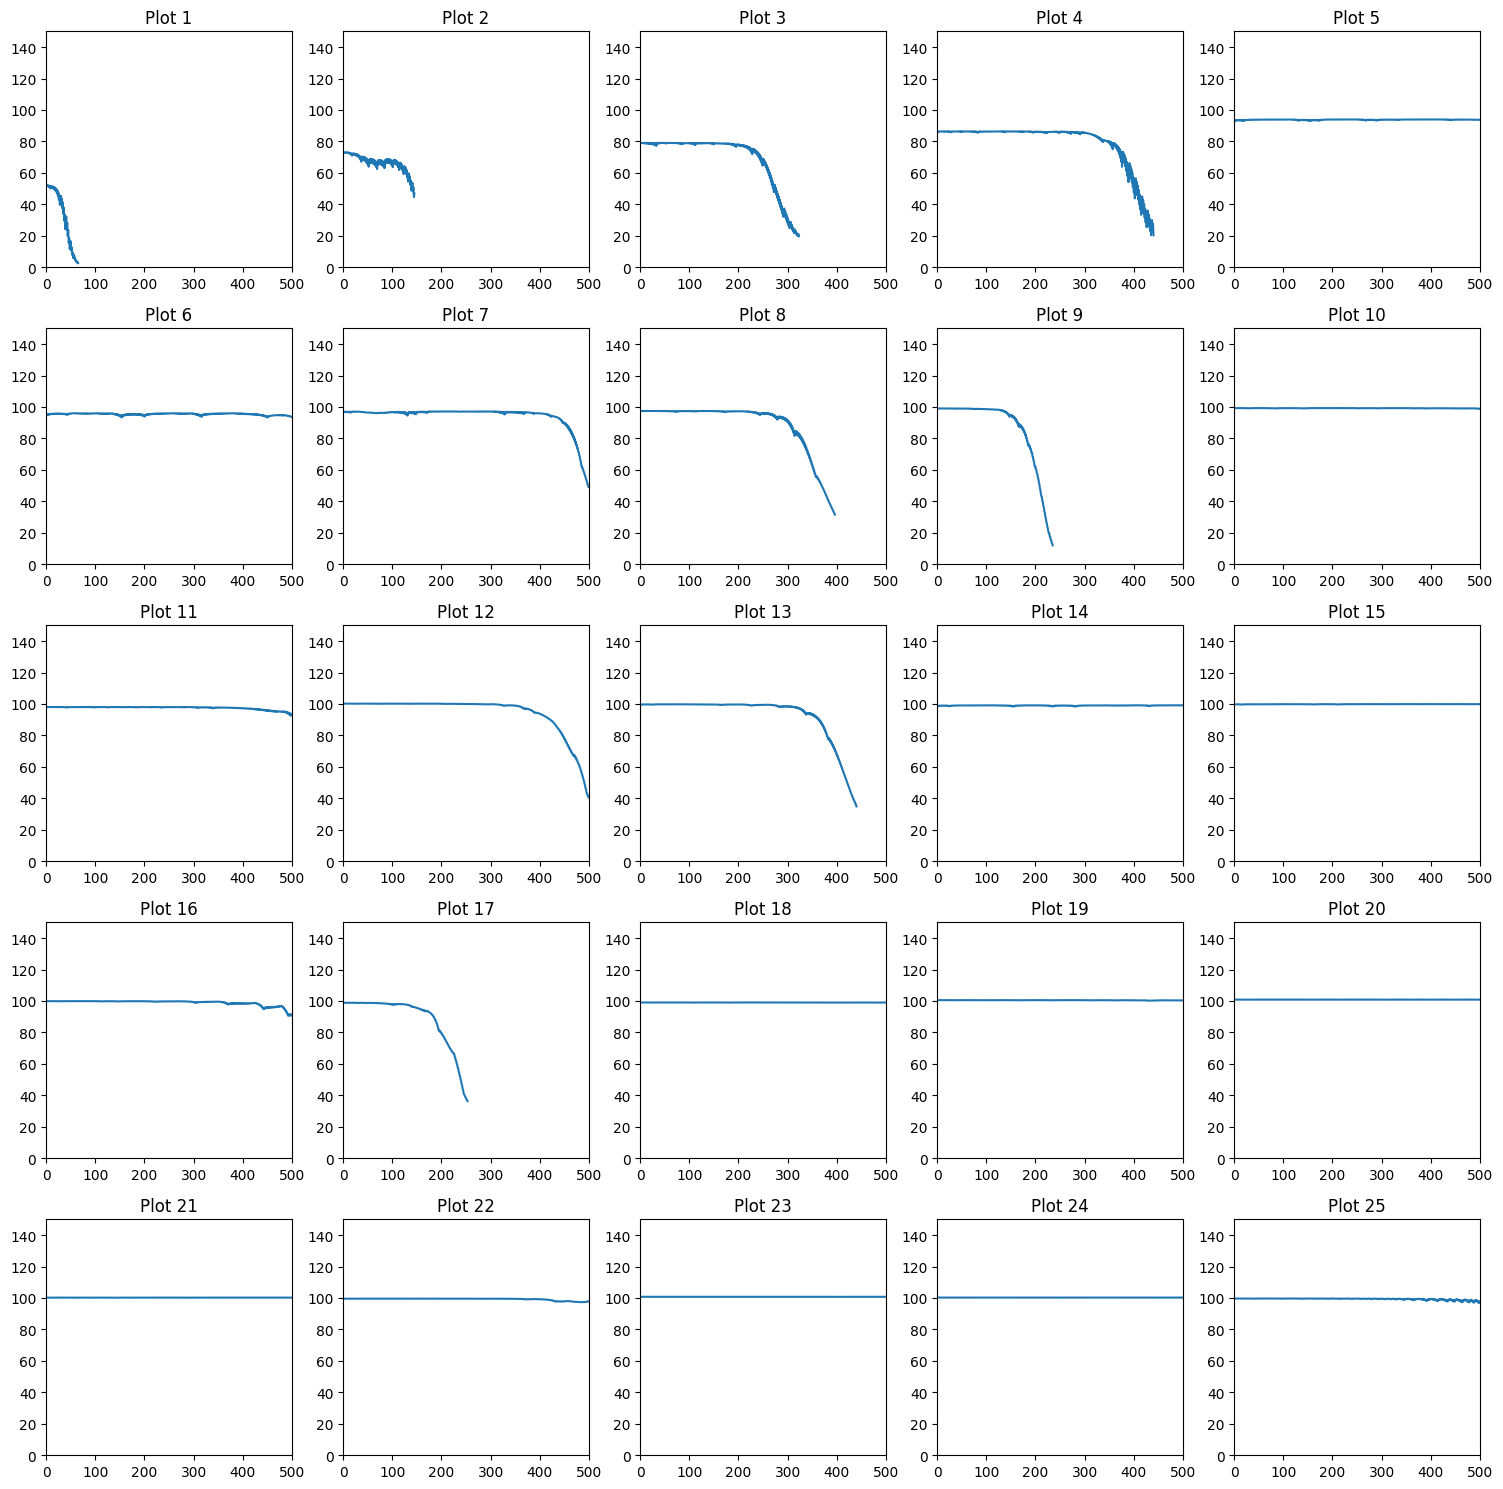

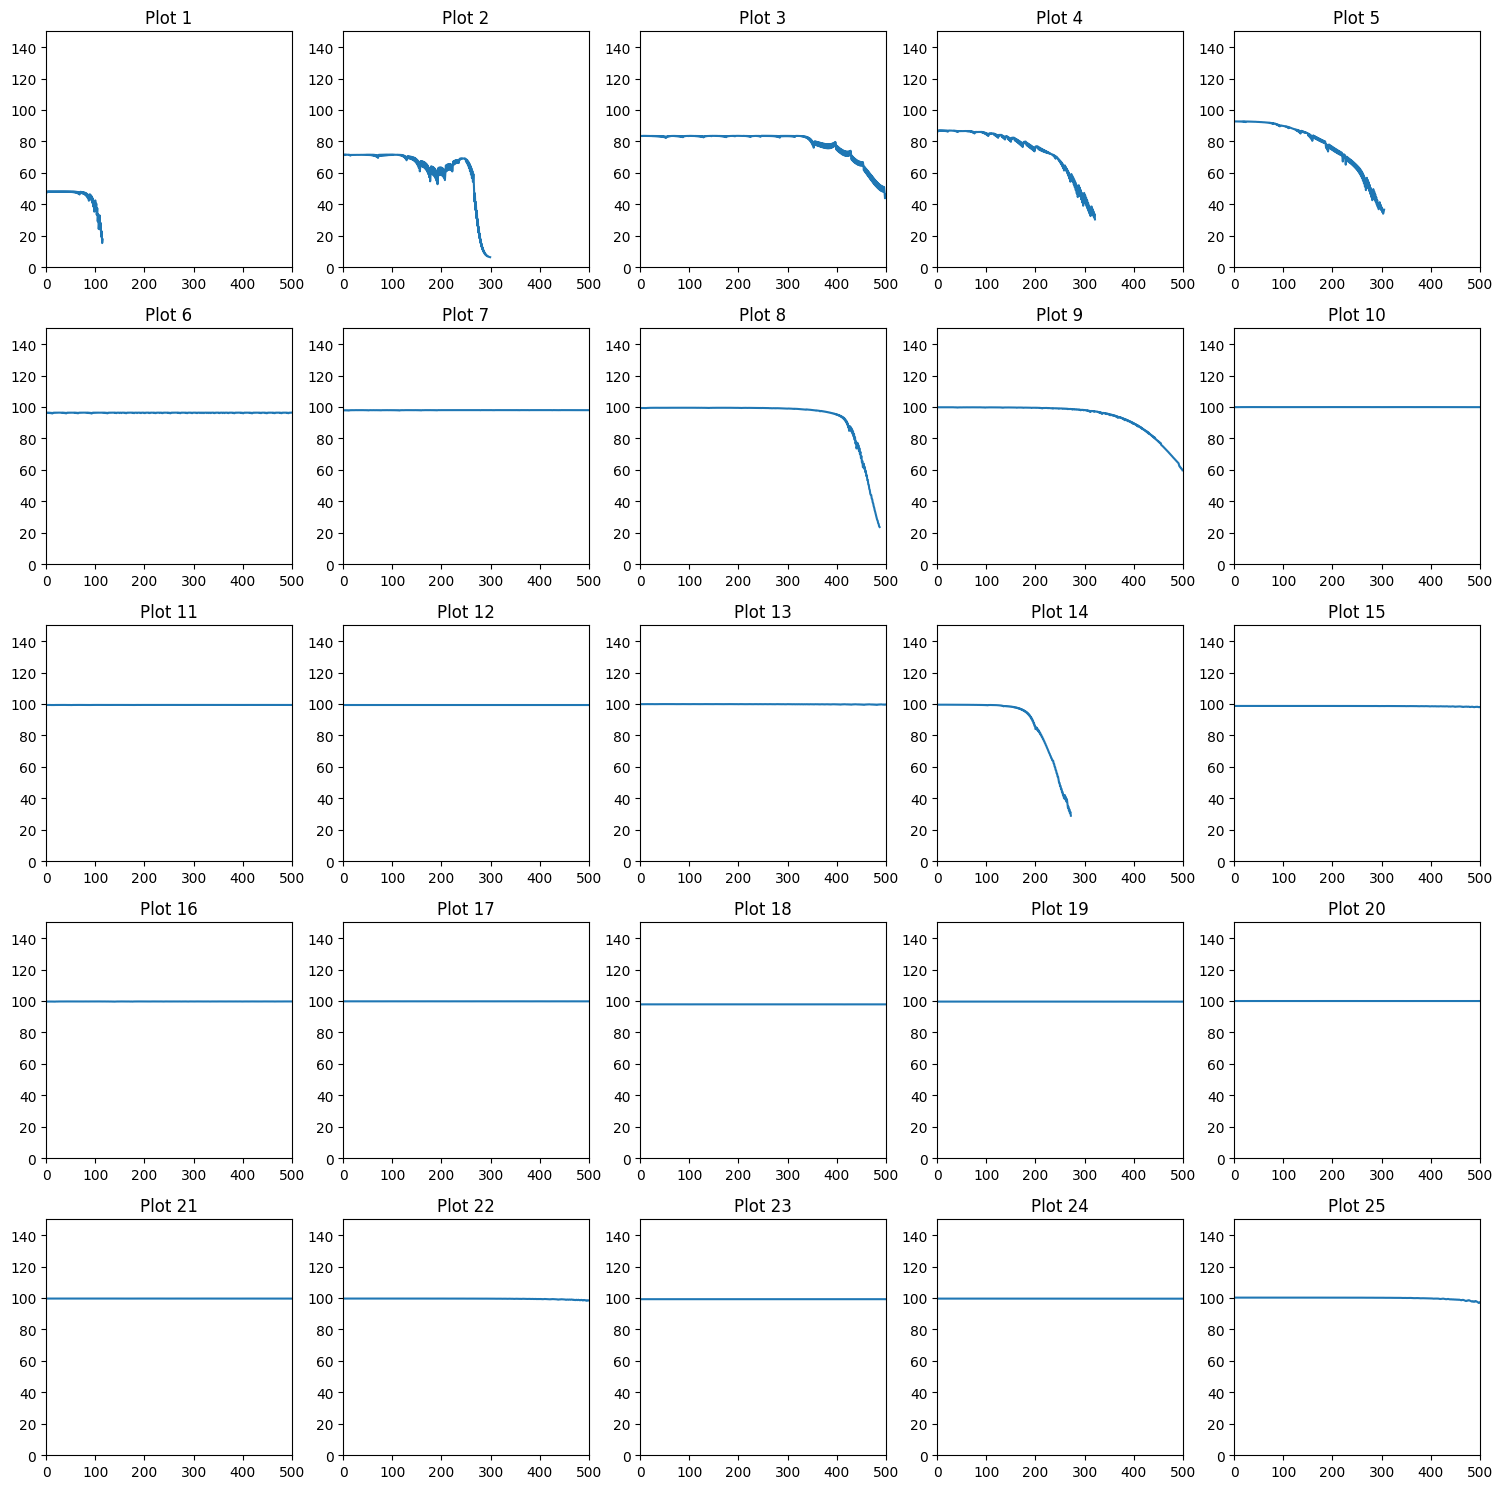

In [40]:
plot_and_save_trajectories(save_plots, folder_name, all_evaluation_value_trajectories, x_range=[0, 500], y_range=[0, 150])


### saving agents and data

In [9]:
folder_name = "data/data_agent3"

os.makedirs(folder_name, exist_ok=True)

# # Save all_* dictionaries
with open(folder_name+'/all_dicts.pkl', 'wb') as f:
    pickle.dump([all_critic_losses, all_actor_losses, all_episode_rewards, \
                 all_evaluation_reward_means, all_evaluation_reward_stds, all_evaluation_value_trajectories], f)

# Save agent3 dictionary
with open(folder_name+'/agent.pkl', 'wb') as f:
    pickle.dump(agent, f)

# # Save seed list used for training
with open(folder_name+'/seeds.pkl', 'wb') as f:
    pickle.dump(seeds, f)